**First International Summer School in Data Science for Mobility (DSM)**, 3-7 October 2022, Santorini, Greece

<img width=200, src="http://master-school.isti.cnr.it/wp-content/uploads/2022/05/logo-Summer-School-Mobility-2022.png"/>

Author: [Luca Pappalardo](https://twitter.com/lucpappalard)

# Mobility Data

In this lesson, we will learn how to handle and explore spatial data in Python using folium and scikit-mobility.

1. [Exploring datasets](#exploring)
    - [GPS traces](#gpstraces)
    - [Geotagged posts](#geotaggedposts)
    - [Skmob data module](#datamodule)
    - [Practice](#practice1)
2. [OSMnx](#osmnx)
    - [Get administrative boundaries](#getboundaries)
    - [Points of Interest and Geospatial entities](#pois)
3. [Exercises](#exercises)

<a id="exploring"></a>
# Exploring datasets in scikit-mobility

One of the use cases for [scikit-mobility](https://github.com/scikit-mobility/scikit-mobility) is the exploratory data analysis of mobility datasets, which includes the visualization of trajectories and flows. 

To this end, both `TrajDataFrame` and `FlowDataFrame` have methods that allow the user to produce interactive visualizations generated using [folium](https://python-visualization.github.io/folium/). 

## Visualizing trajectories

A `TrajDataFrame` has three main plotting methods: 
- `plot_trajectory` plots a line connecting the trajectory points on a map;
- `plot_stops` plots the location of stops on a map; 
- `plot_diary` plots the sequence of visited locations over time.

### Plot trajectories

Method `plot_trajectory` plots the time-ordered trajectory points connected by straight lines on a map. 

If the column `uid`is present and contains more than one object, the trajectory points are first grouped by `uid` and then sorted by `datetime`.

Large `TrajDataFrame`s with many points can be computationally intensive to visualize. Two arguments can be used to reduce the amount of data to plot:
- `max_users` limits the number of objects whose trajectories should be plotted
- `max_points` limits the number of trajectory points per object to plot, i.e., if necessary an object's trajectory will be down-sampled and at most `max_points` points will be plotted.

The plot style can be customized via arguments to specify the color, weight, and opacity of the trajectory lines, as well as the type of map tiles to use. 
The user can also plot markers denoting the start points and the end points of the trajectory. 

The `plot_trajectory` method, as well as all the other plotting methods, return a `folium.Map` object, which can be used by other `folium` and scikit-mobility functions to visualize additional data on the same map. A `folium.Map` object can be passed to a plotting method via the argument `map_f`. If `map_f` is `None`, the trajectories are plotted on a new map.


In [ ]:
# import the library
import skmob
import pandas as pd
import folium
from folium.plugins import HeatMap

In [ ]:
skmob.__version__

In [ ]:
# From a list
data_list = [[1, 39.984044, 116.319236, '2008-10-23 13:53:05'],
             [1, 39.984198, 116.319322, '2008-10-23 13:53:06'],
             [1, 39.974224, 116.319402, '2008-10-23 13:53:11'],
             [1, 39.974211, 116.219389, '2008-10-23 13:53:16']]

In [ ]:
tdf = skmob.TrajDataFrame(data_list, user_id=0, latitude=1, longitude=2, datetime=3)
tdf

In [ ]:
map_f = tdf.plot_trajectory(zoom=12, start_end_markers=True, hex_color='red')
map_f

<a id='gpstraces'></a>
## GPS traces

The [Geolife dataset](https://www.microsoft.com/en-us/download/details.aspx?id=52367&from=https%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fdownloads%2Fb16d359d-d164-469e-9fd4-daa38f2b2e13%2F) is a GPS trajectory dataset collected by Microsoft Research Asia. The dataset describes 182 users in a period of over three years (from April 2007 to August 2012).

In [ ]:
# create a TrajDataFrame from a dataset of GPS traces
url = "https://github.com/scikit-mobility/tutorials/raw/master/mda_masterbd2020/data/geolife_sample.txt.gz"
tdf = skmob.TrajDataFrame.from_file(url)
print(type(tdf))
tdf.head()

In [ ]:
tdf.uid.unique()

In [ ]:
map_f = tdf.plot_trajectory(zoom=12, max_users=2) #hex_color='#000000')
map_f

NOTE: if trajectories represent abstract mobility, such as movements extracted from social media posts or mobile phone records, straight lines may appear that do not consider walls, buildings, and similar structures on the road network. 

## Geotagged traces

Brightkite was once a location-based social networking service provider where users shared their locations by checking-in. The [available dataset](https://snap.stanford.edu/data/loc-brightkite.html) describes friendship network was collected using their public API, and consists of $58,228$ nodes and $214,078$ edges. The network is originally directed but we have constructed a network with undirected edges when there is a friendship in both ways. The dataset also contains a total of $4,491,143$ checkins of these users over the period of Apr. 2008 - Oct. 2010.

In [ ]:
#url = 'https://snap.stanford.edu/data/loc-brightkite_totalCheckins.txt.gz'
url = 'data/loc-gowalla_totalCheckins.txt.gz'
df = pd.read_csv(url, sep = '\t', header = 0, nrows = 100000, 
                 names = ['user', 'check-in_time', 'latitude', 'longitude', 'location id'])
tdf_ci = skmob.TrajDataFrame(df, latitude = 'latitude', longitude = 'longitude', 
                          datetime = 'check-in_time', user_id = 'user').sort_values(by = 'datetime')

In [ ]:
tdf_ci.head()

In [ ]:
map_f = tdf_ci.plot_trajectory(max_users=2, start_end_markers=False, zoom=3)
folium.Marker([0.0, 0.0], popup="Null Island", tooltip="Null Island").add_to(map_f)
map_f

In [ ]:
ni_tdf_ci = tdf_ci[(tdf_ci['lat'] == 0.0) & (tdf_ci['lng'] == 0.0)]
print(len(ni_tdf_ci))
ni_tdf_ci

In [ ]:
map_f = folium.Map(location=[0.0, 0.0], zoom_start = 5) 
heat_data = [[row['lat'],row['lng']] for index, row in tdf_ci.iterrows()]
HeatMap(heat_data).add_to(map_f)
folium.Marker([0.0, 0.0], popup="Null Island", tooltip="Null Island").add_to(map_f)
map_f

## Visualizing flows

A `FlowDataFrame` has two main plotting methods:
- `plot_tessellation` plots the tessellation's tiles on a geographic map;
- `plot_flows` plots, on a geographic map, the lines connecting the centroids of the tessellation's tiles between which flows are present.

### Plot tessellation

Method `plot_tessellation` plots the `GeoDataFrame` associated with a `FlowDataFrame` on a geographic map. 

Large tessellations with many tiles can be computationally intensive to visualize. The argument `maxitems` can be used to limit the number of tiles to plot (default: -1, which means that all tiles are displayed).

The plot style can be customized via arguments to specify the color, opacity of the tiles, and the type of map tiles to use. The argument `popup_features` allows to enhance the plot's interactivity displaying popup windows that appear when the user clicks on a tile and includes information contained in the columns of the tessellation's `GeoDataFrame` specified in the argument's list.

In [ ]:
import geopandas as gpd
from skmob import FlowDataFrame

In [ ]:
url = "https://raw.githubusercontent.com/scikit-mobility/tutorials/master/mda_masterbd2020/data/NY_counties_2011.geojson"
tessellation = gpd.read_file(
    url) # load a tessellation
tessellation.head()

In [ ]:
tessellation.plot()

In [ ]:
from skmob.utils.plot import plot_gdf

In [ ]:
plot_gdf(tessellation)

In [ ]:
url = "https://github.com/scikit-mobility/tutorials/raw/master/mda_masterbd2020/data/NY_commuting_flows_2011.csv"
# create a FlowDataFrame from a file and a tessellation
fdf = skmob.FlowDataFrame.from_file(url, tessellation=tessellation, tile_id='tile_id')
fdf.head()

In [ ]:
fdf.plot_tessellation(popup_features=['tile_id','population'], style_func_args={'fillColor':'black', 'color':'red'})

### Plot flows

Method `plot_flows` plots the flows on a geographic map as lines between the centroids of the tiles in the `FlowDataFrame`'s tessellation. 

Large `FlowDataFrame`s with many origin-destination pairs can be computationally intensive to visualize. The argument `min_flow` can be used to specify that only flows larger than `min_flow` should be displayed. 

The thickness of each line is a function of the flow and can be specified via the arguments `flow_weight`, `flow_exp` and `style_function`. 

The plot style can be further customized via arguments to specify the color, opacity of the flow lines, and the type of map tiles to use. 

The arguments `flow_popup` and `tile_popup` allow enhancing the plot's interactivity displaying popup windows that appear when the user clicks on a flow line or a circle in an origin location, respectively, and include information on the flow or the flows from a location.

In [ ]:
fdf.plot_flows(min_flow=500)

The user can also visualize the tessellation and the flows in the same plot.

In [ ]:
map_f = fdf.plot_tessellation(style_func_args={'fillColor':'blue', 'color':'blue'}) 
fdf.plot_flows(map_f=map_f, min_flow=50)#, flow_exp=0.5)

<a id="datamodule"></a>
## The scikit-mobility data module

The scikit-mobility data module allows you to retrieve mobility datasets via an easy-to-use interface. Look at the documentation [here](https://scikit-mobility.github.io/scikit-mobility/reference/data.html).

The data module API consists of two main functions: `list_datasets` and `load_dataset`. 
- `list_datasets` shows the datasets already available in the repository;
- `load_dataset `retrieves the requested dataset and directly outputs it into a skmob-friendly data structure.

___

The scikit-mobility data types and format to describe mobility data are the following:

- trajectory $\rightarrow$ `TrajDataFrame`
- flow $\rightarrow$ `FlowDataFrame`
- shape $\rightarrow$ `GeoDataFrame`
- auxiliar $\rightarrow$ `DataFrame`

In [ ]:
from skmob.data.load import load_dataset, list_datasets

### `list_datasets()`

`list_datasets` shows the names and information of the datasets already available in the scikit-mobility repository;

In [ ]:
# list all the datasets' names without details

print(list_datasets())

In [ ]:
# list all the datasets with details into a Pandas DataFrame
dataset_details = list_datasets(details=True)
pd.DataFrame.from_dict(dataset_details, orient='index')

In [ ]:
# list all the datasets of type "flow" with details into a Pandas DataFrame
dataset_details = list_datasets(data_types='flow', details=True)
pd.DataFrame.from_dict(dataset_details, orient='index')

In [ ]:
#list all the datasets of type "trajectory" or "shape" with details into a Pandas DataFrame
dataset_details = list_datasets(data_types=['trajectory', 'shape'], details=True)
pd.DataFrame.from_dict(dataset_details, orient='index')

### `load_dataset()`

`load_dataset` retrieves the requested dataset and directly outputs it into a skmob-friendly data structure.

#### Load the Foursquare NYC trajectory dataset

In [ ]:
# loading the trajectory dataset into a TrajDataFrame
tdf_nyc = load_dataset("foursquare_nyc", drop_columns=True)
print(type(tdf_nyc))

In [ ]:
print(tdf_nyc._info)

In [ ]:
type(tdf_nyc)

In [ ]:
tdf_nyc.head()

#### Load the Shape of New York City's boundaries

In [ ]:
# loading the shape into a GeoDataFrame
shape_nyc = load_dataset("nyc_boundaries")
print(type(shape_nyc))

In [ ]:
print(shape_nyc._info)

In [ ]:
shape_nyc = shape_nyc.to_crs("epsg:4326")
shape_nyc.head()

#### Let's use the loaded datasets!

In [ ]:
# plot the trajectories of the first 3 users over the shapefile of New York City

from skmob.utils.plot import plot_gdf

map_f = tdf_nyc.plot_trajectory(max_users=3)
map_f = plot_gdf(shape_nyc, zoom=10, map_f=map_f)

map_f

<a id="practice1"></a>
## Practice
Download and explore the [Gowalla checkins dataset](https://snap.stanford.edu/data/loc-gowalla.html).

Gowalla was a location-based social networking website where users share their locations by checking-in. The dataset contains a friendship network (undirected) collected using their public API, and consists of $196,591$ nodes and $950,327$ edges. The dataset also contains a total of $6,442,890$ check-ins of these users over the period of Feb. 2009 - Oct. 2010.

In [ ]:
#url = 'https://snap.stanford.edu/data/loc-gowalla_totalCheckins.txt.gz'
url = 'data/loc-gowalla_totalCheckins.txt.gz'
df = pd.read_csv(url, sep = '\t', header = 0, nrows = 100000, 
                 names = ['user', 'check-in_time', 'latitude', 'longitude', 'location id'])
tdf_gow = skmob.TrajDataFrame(df, latitude = 'latitude', longitude = 'longitude', 
                          datetime = 'check-in_time', user_id = 'user').sort_values(by = 'datetime')
print(len(tdf_gow))
tdf_gow.head()

In [ ]:
map_f = tdf_gow.plot_trajectory(max_users=200, start_end_markers=False, zoom=3)
folium.Marker([0.0, 0.0], popup="Null Island", tooltip="Null Island").add_to(map_f)
map_f

Can we find checkins in null island? Make a heatmap to show it.

In [ ]:
map_f = folium.Map(location=[0.0, 0.0], zoom_start = 5) 
heat_data = [[row['lat'],row['lng']] for index, row in tdf_gow.iterrows()]
HeatMap(heat_data).add_to(map_f)
folium.Marker([0.0, 0.0], popup="Null Island", tooltip="Null Island").add_to(map_f)
map_f

Select and visualize all checkins in Pisa

In [ ]:
from skmob.tessellation import tilers

In [ ]:
pisa_tess = tilers.tiler.get("squared", base_shape='Pisa, Italy', meters=10000)
pisa_tess.crs = 'epsg: 4326'
pisa_tess

In [ ]:
tdf_gow.mapping(pisa_tess, remove_na=True).plot_stops()

<a id="osmnx"></a>
# OSMnx

<img width=200, src="https://automating-gis-processes.github.io/CSC/_images/OSM_logo.png"/>

[***OSMnx***](https://www.sciencedirect.com/science/article/pii/S0198971516303970) is a Python package to retrieve, model, analyze, and visualize street networks from [OpenStreetMap](https://www.openstreetmap.org/). Users can download and model walkable, drivable, or bikeable urban networks with a single line of Python code, and then easily analyze and visualize them. You can just as easily download and work with amenities/points of interest, building footprints, elevation data, street bearings/orientations, and network routing. 

In [1]:
import osmnx as ox

/Users/lucapappalardo/opt/anaconda3/envs/GSA/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


<a id="getboundaries"></a>
## Get administrative place boundaries and shapefiles
With OSMnx, you can download place shapes from OpenStreetMap (as geopandas `GeoDataFrame`s) in one line of Python code – and project them to UTM (zone calculated automatically) and visualize in just one more line of code:

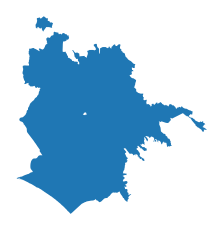

In [2]:
city = ox.geocode_to_gdf('Rome, Italy')
ax = ox.project_gdf(city).plot()
_ = ax.axis('off')

In [3]:
city

geometry  bbox_north  bbox_south  \
0  MULTIPOLYGON (((12.23447 41.74005, 12.23459 41...   42.141028   41.655642   

   bbox_east  bbox_west   place_id  osm_type  osm_id       lat        lon  \
0   12.85576  12.234467  297859951  relation   41485  41.89332  12.482932   

                        display_name     class            type  importance  
0  Rome, Roma Capitale, Lazio, Italy  boundary  administrative    1.009611

You can just as easily get other place types, such as neighborhoods, boroughs, counties, states, or nations – any place geometry in OpenStreetMap:

In [4]:
place1 = ox.geocode_to_gdf('Pisa, Italy')
place2 = ox.geocode_to_gdf('Italy')
place3 = ox.geocode_to_gdf('Manhattan, New York City, New York, USA')
place4 = ox.geocode_to_gdf('Tuscany, Italy')

<AxesSubplot:>

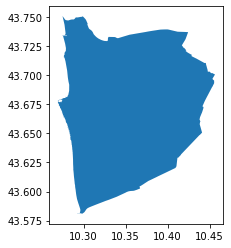

In [5]:
place1.plot()

<AxesSubplot:>

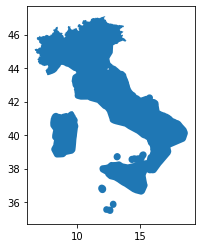

In [6]:
place2.plot()

<AxesSubplot:>

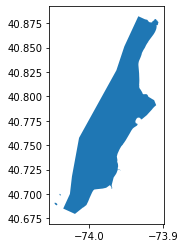

In [7]:
place3.plot()

<AxesSubplot:>

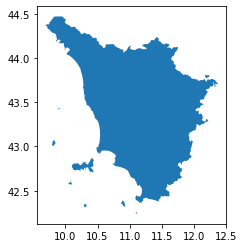

In [8]:
place4.plot()

<AxesSubplot:>

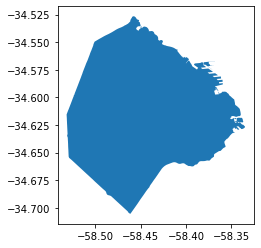

In [14]:
ox.geocode_to_gdf('Buenos Aires, Argentina').plot()

Or you can pass multiple places into a single query to save a single shapefile or geopackage from their geometries. You can do this with cities, states, countries or any other geographic entities:

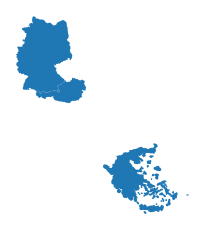

In [16]:
places = ox.geocode_to_gdf(['Greece', 'Austria', 'Germany'])
places = ox.project_gdf(places)
ax = places.plot()
_ = ax.axis('off')

In [17]:
places

geometry  bbox_north  bbox_south  \
0  MULTIPOLYGON (((851842.151 4420136.728, 851853...   41.748889   34.718886   
1  MULTIPOLYGON (((158052.968 5276950.335, 158016...   49.020525   46.372299   
2  MULTIPOLYGON (((158052.968 5276950.335, 158142...   55.099161   47.270111   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat        lon  \
0  29.683810  19.112754  297981835  relation  192307  38.995368  21.987713   
1  17.160773   9.530749  297586455  relation   16239  47.593970  14.124560   
2  15.041931   5.866315  297629585  relation   51477  51.163818  10.447831   

  display_name     class            type  importance  
0       Greece  boundary  administrative    0.908996  
1      Austria  boundary  administrative    0.933044  
2      Germany  boundary  administrative    0.999681

<a id="pois"></a>
# Points of Interest and Geospatial Entities
The `geometries` module of OSMnx allows downloading entities, such as grocery stores, transit stops, points of interest (POIs), or building footprints, and turn them into a `GeoDataFrame`.

To query, pass a tags dict where keys are OSM tags. The dict's values can be either:

- True to retrieve all OSM objects with this tag, regardless of its value
- a single value as a string to retrieve all OSM objects with this tag:value combination
- a list of string values to retrieve all OSM objects where this tag matches any of these values

Pass multiple dict key:value pairs to retrieve the union (not intersection) of these pairs.

See [docs](https://wiki.openstreetmap.org/wiki/Map_features).

In [18]:
# get all building footprints in some neighborhood
# `True` means retrieve any object with this tag, regardless of value
place = "Aeroporto Galileo Galilei, Pisa, Italy"
#place = 'Bunker Hill, Los Angeles, California'
tags = {"building": True}
gdf = ox.geometries_from_place(place, tags)
gdf.shape

(2, 12)

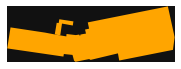

In [19]:
fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

In [20]:
# get all the parks in some neighborhood
# constrain acceptable `leisure` tag values to `park`
place = "Pisa, Italy"
tags = {"leisure": "park"}
gdf = ox.geometries_from_place(place, tags)
gdf.shape

(152, 30)

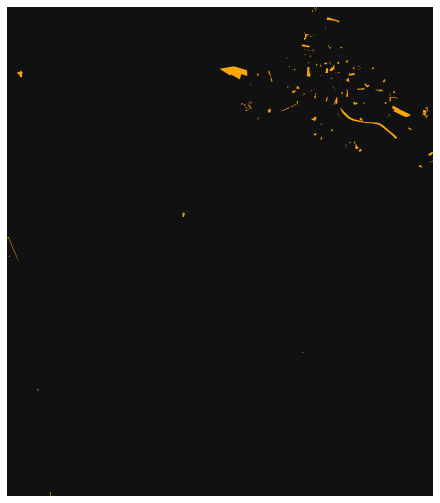

In [21]:
fig, ax = ox.plot_footprints(gdf, figsize=(9, 9))

In [22]:
# get all the parks in some neighborhood
# constrain acceptable `leisure` tag values to `park`
place = "Rome, Italy"
tags = {"leisure": "park"}
gdf = ox.geometries_from_place(place, tags)
gdf.shape

(1061, 90)

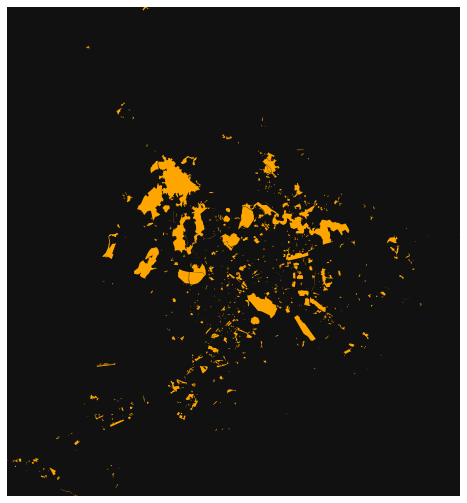

In [23]:
fig, ax = ox.plot_footprints(gdf, figsize=(9, 9))

In [25]:
import folium

In [26]:
centroid = gdf.centroid.iloc[0]
map_f = folium.Map(location=[centroid.y, centroid.x])
geo_j = gdf.to_json()
geo_j = folium.GeoJson(data=geo_j,
                       style_function=lambda x: {'fillColor': 'red', 'weight': 1})
geo_j.add_to(map_f)
map_f

/var/folders/l4/n69k0p694d95z18vym8s17xm0000gn/T/ipykernel_40152/1945419958.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf.centroid.iloc[0]


In [27]:
# get everything tagged amenity,
# and everything tagged landuse = retail or commercial,
# and everything tagged highway = bus_stop
tags = {"amenity": True, "landuse": ["retail", "commercial"], "highway": "bus_stop"}
gdf = ox.geometries_from_place("Piedmont, California, USA", tags)
gdf.shape

(139, 61)

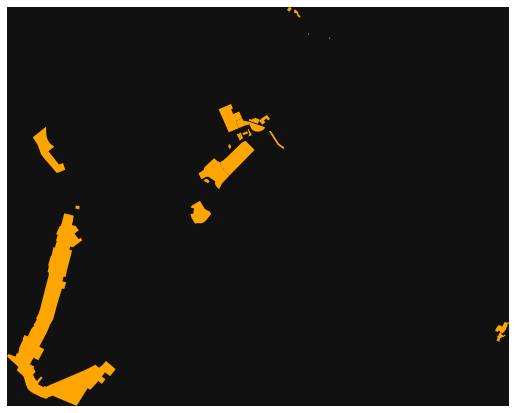

In [28]:
fig, ax = ox.plot_footprints(gdf, figsize=(9, 9))

In [29]:
centroid = gdf.centroid.iloc[0]
map_f = folium.Map(location=[centroid.y, centroid.x])
geo_j = gdf.to_json()
geo_j = folium.GeoJson(data=geo_j,
                       style_function=lambda x: {'fillColor': 'red', 'weight': 1})
geo_j.add_to(map_f)
map_f

/var/folders/l4/n69k0p694d95z18vym8s17xm0000gn/T/ipykernel_40152/1945419958.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf.centroid.iloc[0]


## Practice: Let's take all restaurants in Lucca

In [30]:
# get all the parks in some neighborhood
# constrain acceptable `leisure` tag values to `park`
tags = {"building": 'supermarket'}
gdf = ox.geometries_from_place('Lucca, Italy', tags)
gdf.shape

(3, 10)

In [31]:
gdf.head()

nodes  \
element_type osmid                                                          
way          159244265  [1713360321, 1713360197, 1713360124, 364563816...   
             369134743  [3729500013, 3729506434, 3729500023, 372950642...   
             397606141  [4003913446, 4003913440, 4003913442, 400391344...   

                           building  check_date                    name  \
element_type osmid                                                        
way          159244265  supermarket  2022-09-03  Esselunga dell'Arancio   
             369134743  supermarket         NaN                     NaN   
             397606141  supermarket         NaN                    Coop   

                       payment:mastercard payment:visa         shop  \
element_type osmid                                                    
way          159244265                yes          yes  supermarket   
             369134743                NaN          NaN          NaN   
             397606141                NaN          NaN  supermarket   

                       toilets:wheelchair wheelchair  \
element_type osmid                                     
way          159244265                yes        yes   
             369134743                NaN        NaN   
             397606141                NaN        NaN   

                                                                 geometry  
element_type osmid                                                         
way          159244265  POLYGON ((10.52615 43.84889, 10.52613 43.84871...  
             369134743  POLYGON ((10.49934 43.84902, 10.49949 43.84859...  
             397606141  POLYGON ((10.52957 43.84147, 10.52947 43.84088...

<AxesSubplot:>

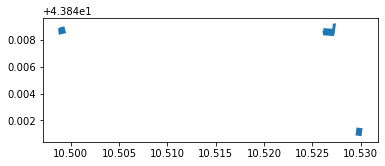

In [32]:
gdf.plot()

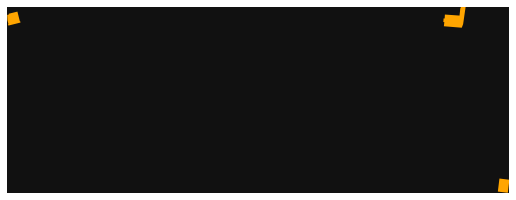

In [33]:
fig, ax = ox.plot_footprints(gdf, figsize=(9, 9))

In [34]:
centroid = gdf.centroid.iloc[0]
map_f = folium.Map(location=[centroid.y, centroid.x], zoom_start=14)
geo_j = gdf.to_json()
geo_j = folium.GeoJson(data=geo_j,
                       style_function=lambda x: {'fillColor': 'blue', 'weight': 1})
geo_j.add_to(map_f)
map_f

/var/folders/l4/n69k0p694d95z18vym8s17xm0000gn/T/ipykernel_40152/2416187028.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf.centroid.iloc[0]


All stadiums in London

In [35]:
# get all the parks in some neighborhood
# constrain acceptable `leisure` tag values to `park`
tags = {"building": 'stadium'}
gdf = ox.geometries_from_place('London, UK', tags)
gdf.shape

(70, 44)

In [36]:
gdf

geometry  \
element_type osmid                                                         
way          4253703   POLYGON ((-0.34343 51.45082, -0.34320 51.45093...   
             4270350   POLYGON ((-0.03821 51.63075, -0.03810 51.63099...   
             4629309   POLYGON ((-0.08460 51.46158, -0.08407 51.46182...   
             18926807  POLYGON ((-0.17118 51.39340, -0.17129 51.39332...   
             57869057  POLYGON ((-0.01141 51.54062, -0.01143 51.54060...   
...                                                                  ...   
relation     1949061   POLYGON ((-0.34211 51.45723, -0.34161 51.45727...   
             2548271   POLYGON ((-0.21498 51.43281, -0.21496 51.43285...   
             4087734   POLYGON ((-0.19061 51.48084, -0.19066 51.48082...   
             7708006   POLYGON ((-0.06728 51.60502, -0.06718 51.60507...   
             10266378  POLYGON ((-0.01734 51.53986, -0.01713 51.53994...   

                                                                 note  \
element_type osmid                                                      
way          4253703                                              NaN   
             4270350                                              NaN   
             4629309                                              NaN   
             18926807  name amended to correspond to its own web site   
             57869057                                             NaN   
...                                                               ...   
relation     1949061                                              NaN   
             2548271                                              NaN   
             4087734                                              NaN   
             7708006                                              NaN   
             10266378                                             NaN   

                                                name wheelchair description  \
element_type osmid                                                            
way          4253703                       DHL Stand        NaN         NaN   
             4270350                             NaN        NaN         NaN   
             4629309                             NaN        NaN         NaN   
             18926807  Tooting and Mitcham United FC        NaN         NaN   
             57869057         London Aquatics Centre        yes         NaN   
...                                              ...        ...         ...   
relation     1949061                             NaN        NaN         NaN   
             2548271                             NaN        NaN         NaN   
             4087734                             NaN        NaN         NaN   
             7708006       Tottenham Hotspur Stadium        NaN         NaN   
             10266378                            NaN        NaN         NaN   

                      layer  \
element_type osmid            
way          4253703    NaN   
             4270350    NaN   
             4629309    NaN   
             18926807   NaN   
             57869057     2   
...                     ...   
relation     1949061    NaN   
             2548271    NaN   
             4087734    NaN   
             7708006    NaN   
             10266378   NaN   

                                                                   nodes  \
element_type osmid                                                         
way          4253703   [25473012, 3326373714, 25473013, 8897543150, 5...   
             4270350   [25637054, 8772069299, 8770493875, 8772069300,...   
             4629309   [939600798, 939600574, 939601531, 29400411, 62...   
             18926807  [195855393, 195855396, 195855400, 195855402, 1...   
             57869057  [717876172, 1836464937, 1409894767, 1836464916...   
...                                                                  ...   
relation     1949061   [[[25472652, 25472653, 25472655, 1574389714, 2...   
         

<AxesSubplot:>

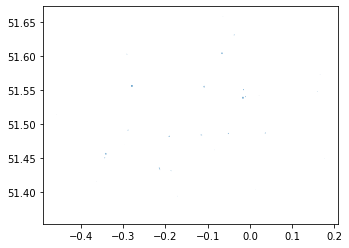

In [37]:
gdf.plot()

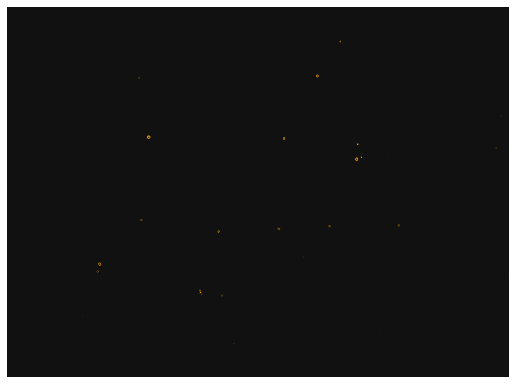

In [38]:
fig, ax = ox.plot_footprints(gdf, figsize=(9, 9))

In [39]:
centroid = gdf.centroid.iloc[0]
map_f = folium.Map(location=[centroid.y, centroid.x], zoom_start=14)
geo_j = gdf.to_json()
geo_j = folium.GeoJson(data=geo_j,
                       style_function=lambda x: {'fillColor': 'blue', 'weight': 1})
geo_j.add_to(map_f)
map_f

/var/folders/l4/n69k0p694d95z18vym8s17xm0000gn/T/ipykernel_40152/2416187028.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf.centroid.iloc[0]


<a id="exercises"></a>
## Exercises

**Exercise 2.1**: Download Cell Towers data about France from [OpenCellID](https://opencellid.org/). Then, create and visualize (in folium) a Voronoi tessellation of GSM towers in Lyon, France.
- Use the [geovoronoi](https://pypi.org/project/geovoronoi/) package to create the Voronoi tessellation
- Plot the tessellation with folium (Use just a random sample if the towers if they are too many to be visualized and/or to compute the tessellation) 


**Exercise 2.2**: Use OSMnx to download the shapes of all cinemas in Rome.
- Plot in folium the shape of the municipality of Rome
- Plot the smallest polygon that contains all cinemas in Rome
- Plot the cinemas in folium with a pop-up showing their name
- Compute the cinemas with the lowest and highest average distance to the others, and draw a circle (of radius 100m)


**Exercise 2.3**: Download from figshare this [flows dataset](https://figshare.com/collections/Inter-urban_interactions_of_mobility_via_cellular_position_tracking_in_the_southeast_Songliao_Basin_Northeast_China/4226183), create a tessellation and a `FlowDataFrame`; plot them together using skmob.
